# **Modelling**

# Baseline model

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

In [55]:
df = pd.read_csv("dataset.csv") #Load the dataset

In [56]:
df.columns = df.columns.str.strip() #Some column names weren't getting identified so remove any extra spaces
df = df.drop(columns=['Random', 'Class', 'ADWV', 'AWWGV']) #Drop some columns as mentioned in the write-up
X = df.drop(columns=['PDMVG']) #Drop the target
y = df['PDMVG'] #Define the target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Train-test split
cat_cols = X.select_dtypes(include='object').columns.tolist() #Categorical columns (I think all the categorical columns were dropped but incase)

In [57]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
baseline_pred = [y_train.mean()] * len(y_test)
baseline_mse = mean_squared_error(y_test, baseline_pred)
print("Baseline MSE:", baseline_mse)
baseline_r2 = r2_score(y_test, baseline_pred)
print("Baseline R²:", baseline_r2)

Baseline MSE: 92.67645799779781
Baseline R²: -0.000451133383166491


Multiple regression model

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Train-test split again

In [59]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),remainder='passthrough') #Make transformer

In [60]:
pipe_lr = Pipeline([('encode', transformer),('model', LinearRegression())]) #Make pipeline

In [61]:
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test) #Predict y values

In [62]:
#Find and display the coefficients for analysis in the write-up
lr = pipe_lr.named_steps['model']
coefficients = lr.coef_
names = pipe_lr.named_steps['encode'].get_feature_names_out()
pd.DataFrame(coefficients, names, columns=["Coefficients"])

,Coefficients
remainder__ACHP,-0.165180
remainder__PHR,0.303977
remainder__ALAP,0.018714
remainder__ANPL,6.289172
remainder__ARD,5.704540
remainder__ADWR,-10.066891
remainder__ARL,-1.638046
remainder__AWWR,-10.781536
remainder__PDMRG,-0.036681


In [63]:
lr.intercept_ #Find the y intercept

np.float64(-54.30151630739164)

In [64]:
y_train_preds = pipe_lr.predict(X_train)
mean_squared_error(y_train, y_train_preds) #MSE train

26.276773329323547

In [65]:
y_test_preds = pipe_lr.predict(X_test)
mean_squared_error(y_test, y_test_preds) #MSE test

27.206166108952477

In [66]:
r_squared = r2_score(y_test, y_test_preds)
print("R² Score:", r_squared) #R^2 value

R² Score: 0.7063068625328888


In [67]:
#Use the permutation importance method to find which features are the most important
from sklearn.inspection import permutation_importance
r = permutation_importance(pipe_lr, X_test, y_test, n_repeats=10, random_state=42)
pd.DataFrame(r['importances_mean'], index=pipe_lr.named_steps['encode'].get_feature_names_out(), columns=["Importance"])

,Importance
remainder__ACHP,0.010222
remainder__PHR,0.292391
remainder__ALAP,0.507483
remainder__ANPL,0.421419
remainder__ARD,5.985737
remainder__ADWR,0.467351
remainder__ARL,0.508163
remainder__AWWR,4.814308
remainder__PDMRG,0.001533


In [68]:
print("Linear regression MSE:", mean_squared_error(y_test, y_pred))
print("Linear regression R^2:", r2_score(y_test, y_pred))

Linear regression MSE: 27.206166108952477
Linear regression R^2: 0.7063068625328888


K-Nearest Neighbours

In [69]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
pipe_knn = Pipeline([('encode', transformer),('model', KNeighborsRegressor())]) #KNN pipeline

In [70]:
param_grid = {'model__n_neighbors': [5, 10, 15, 30]}

In [71]:
grid_knn = GridSearchCV(pipe_knn, param_grid, scoring='neg_mean_squared_error') #Grid search
grid_knn.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as a different type depending on the ColumnTransformer inputs.
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('encode',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         [])])),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__n_neighbors': [5, 10, 15, 30]},
             scoring='neg_mean_squared_error')

In [72]:
grid_knn.best_params_ #Best number of neighbours

{'model__n_neighbors': 30}

In [73]:
knn = grid_knn.best_estimator_

In [74]:
y_train_preds = knn.predict(X_train)
mean_squared_error(y_train, y_train_preds) #MSE train

9.583440247438497e-05

In [75]:
y_test_preds = knn.predict(X_test)
mean_squared_error(y_test, y_test_preds) #MSE test

0.0001000495232849192

In [76]:
r_squared = r2_score(y_test, y_test_preds)
print("R^2:", r_squared) #R^2 value

R^2: 0.9999989199559292


In [77]:
#Importance of features in KNN
r = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)
importances_df = pd.DataFrame(r['importances_mean'], index=X_train.columns.tolist(), columns=['Importance'])
importances_df.sort_values(by='Importance', ascending=False)

,Importance
ALAP,1.715959e+00
PHR,4.355839e-01
ACHP,2.565259e-02
PDMRG,5.035985e-07
ARD,2.709552e-07
ARL,5.549196e-09
AWWR,2.022070e-09
ADWR,1.384532e-09
ANPL,-2.959635e-09


Decision tree regression model

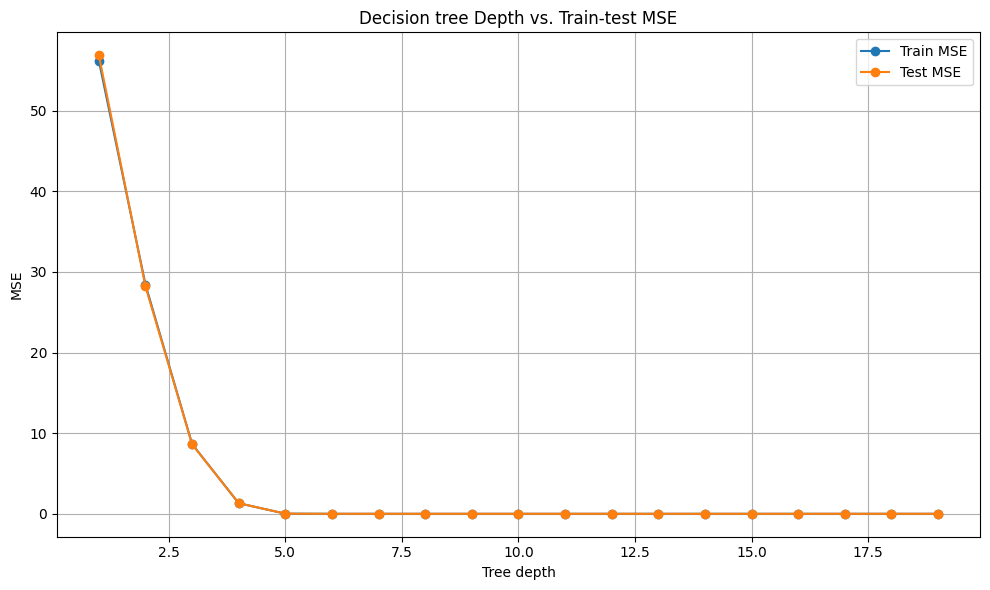

In [78]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Train-test split
transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),remainder=StandardScaler()) #Transformer
X_train_encoded = transformer.fit_transform(X_train)
X_test_encoded = transformer.transform(X_test)

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

train_scores = []
test_scores = []

for d in range(1, 20):
    dt = DecisionTreeRegressor(max_depth=d, random_state=42)
    dt.fit(X_train_encoded, y_train)
    train_scores.append(mean_squared_error(y_train, dt.predict(X_train_encoded)))
    test_scores.append(mean_squared_error(y_test, dt.predict(X_test_encoded)))

#Plot the train test MSE against the number of layers of the decision tree
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), train_scores, label='Train MSE', marker='o')
plt.plot(range(1, 20), test_scores, label='Test MSE', marker='o')
plt.xlabel("Tree depth")
plt.ylabel("MSE")
plt.title("Decision tree Depth vs. Train-test MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
from sklearn.tree import DecisionTreeRegressor
best_depth = 5
dtree = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
dtree.fit(X_train_encoded, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [80]:
y_train_pred = dtree.predict(X_train_encoded)
y_test_pred = dtree.predict(X_test_encoded)
print("Train MSE:", round(mean_squared_error(y_train, y_train_pred), 5))
print("Test MSE:", round(mean_squared_error(y_test, y_test_pred), 5))

Train MSE: 0.01614
Test MSE: 0.01618


In [81]:
r_squared = r2_score(y_test, y_test_pred)
print("R² Score:", r_squared)

R² Score: 0.9998253154024503


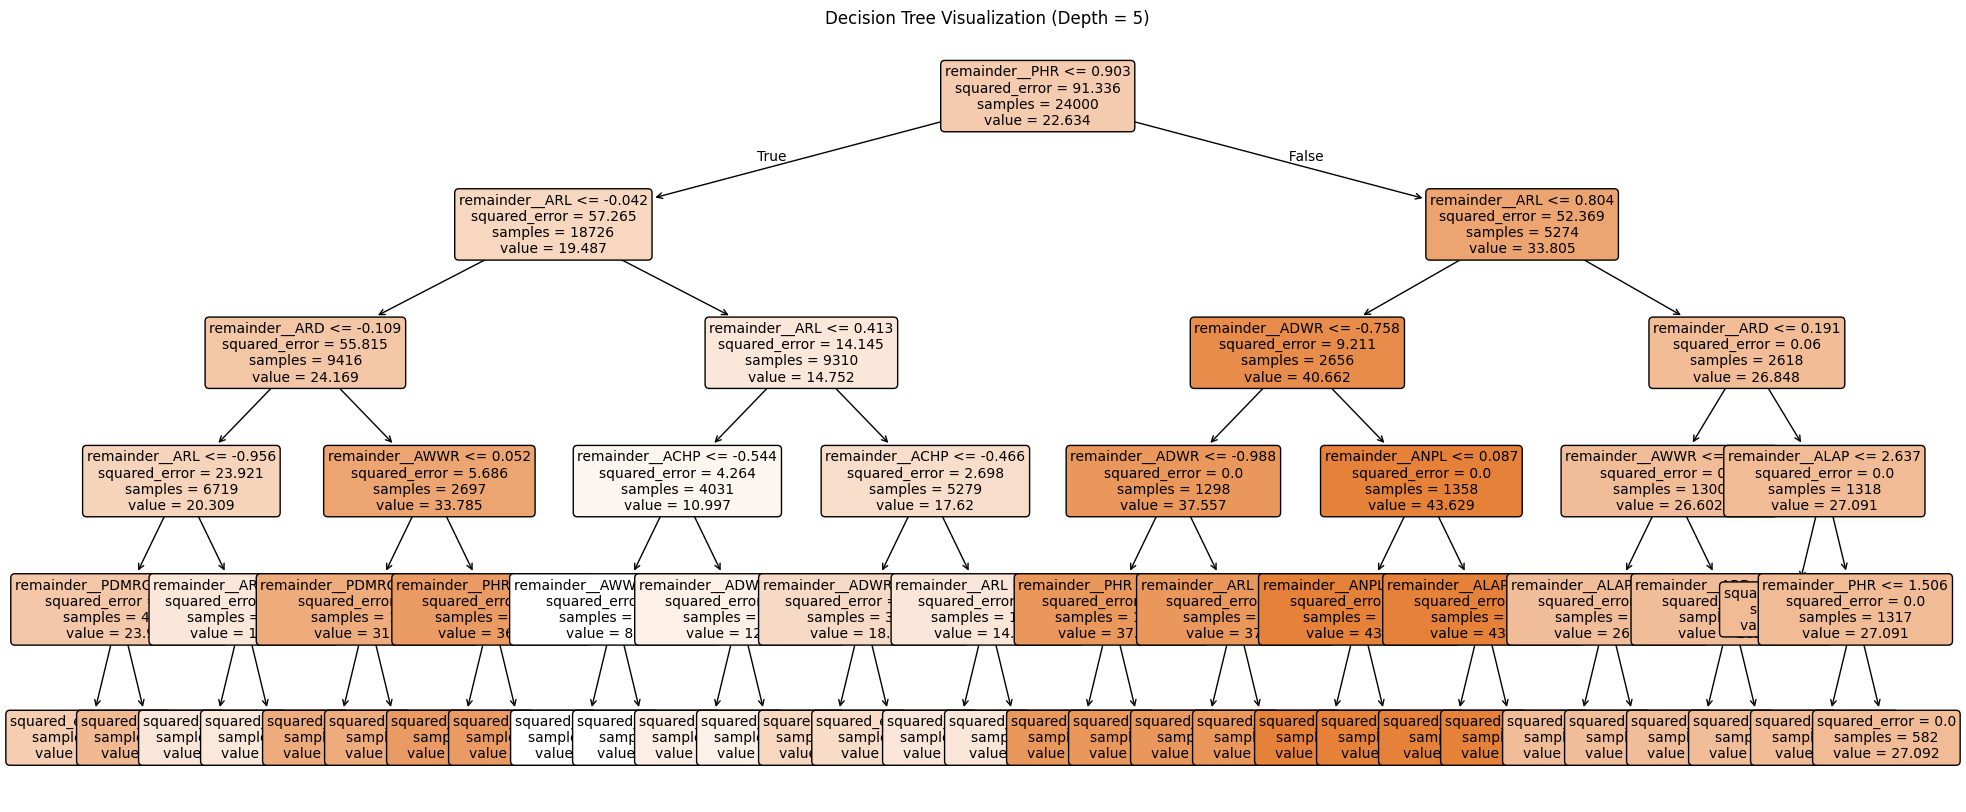

In [82]:
#Visualizing the decision tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(24, 10))
plot_tree(dtree,feature_names=transformer.get_feature_names_out(), filled=True, rounded=True, fontsize=10)
plt.title(f"Decision Tree Visualization (Depth = {best_depth})")
plt.show()

Random forest model

In [94]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
cat_col = X.select_dtypes(include='object').columns.tolist()
transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), cat_col),remainder=StandardScaler())

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
pipe = Pipeline([('encode', transformer),('model', RandomForestRegressor(random_state=42))])

In [96]:
param_grid = {'model__n_estimators': [50, 100, 150, 200],'model__max_depth': [3, 4, 5, 6, 10]}

In [97]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as a different type depending on the ColumnTransformer inputs.
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encode',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         [])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__max_depth': [3, 4, 5, 6, 10],
                         'model__n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_squared_error')

In [98]:
forest = grid_search.best_estimator_

In [99]:
y_train_pred = forest.predict(X_train)
mean_squared_error(y_train, y_train_pred)

9.657322413520363e-05

In [100]:
y_test_pred = forest.predict(X_test)
mean_squared_error(y_test, y_test_pred)

9.721872774130987e-05

In [101]:
r_squared = r2_score(y_test, y_test_pred)
print("R^2:", r_squared)

R^2: 0.9999989505146349


In [102]:
r = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({"Feature": X_train.columns,"Importance": r.importances_mean}).sort_values(by="Importance", ascending=False)
importance_df.head(10)

,Feature,Importance
1,PHR,1.458309
6,ARL,1.181390
7,AWWR,0.061451
4,ARD,0.042569
0,ACHP,0.020150
2,ALAP,0.003216
8,PDMRG,0.002839
3,ANPL,0.000914
5,ADWR,0.000375


Neural network regression pipeline

In [103]:
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cate_cols = X.select_dtypes(include='object').columns.tolist()
transformer = make_column_transformer((Pipeline([('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())]), numeric_cols),(Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))]), cate_cols))
pipenn = Pipeline([('encode', transformer),('model', MLPRegressor(hidden_layer_sizes=(100, 50),activation='relu',solver='adam',max_iter=500,random_state=42))])
pipenn.fit(X_train, y_train)
y_pred_train = pipenn.predict(X_train)
y_pred_test = pipenn.predict(X_test)
print("Train MSE:", mean_squared_error(y_train, y_pred_train))
print("Test MSE:", mean_squared_error(y_test, y_pred_test))
print("Test R squared:", r2_score(y_test, y_pred_test))

Train MSE: 0.002856411289467239
Test MSE: 0.0027004053156266077
Test R squared: 0.9999708488690982
